In [1]:
from tensorflow import keras

In [2]:
from preprocessing_utils import PreprocessingUtils

In [3]:
from model_wrapper import ModelWrapper

In [4]:
preprocessing_utils = PreprocessingUtils()

Files already exist, skipping...
Loading images and labels...
Images and labels loaded successfully!
Preprocessing labels...
Labels preprocessed successfully!
Splitting data into train, test and validation sets...
Data split successfully!


In [5]:
def inception_module(x, filters: list[int]):
    tower_1 = keras.layers.Conv2D(filters[0], (1, 1), padding="same", activation="relu")(x)
    tower_1 = keras.layers.Conv2D(filters[1], (3, 3), padding="same", activation="relu")(tower_1)

    tower_2 = keras.layers.Conv2D(filters[2], (1, 1), padding="same", activation="relu")(x)
    tower_2 = keras.layers.Conv2D(filters[3], (5, 5), padding="same", activation="relu")(tower_2)

    tower_3 = keras.layers.AveragePooling2D((3, 3), strides=(1, 1), padding="same")(x)
    tower_3 = keras.layers.Conv2D(filters[4], (1, 1), padding="same", activation="relu")(tower_3)

    tower_4 = keras.layers.Conv2D(filters[5], (1, 1), padding="same", activation="relu")(x)

    concatenated = keras.layers.Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
    return concatenated


def build_google_net(model_name: str):
    input_layer = keras.layers.Input(shape=preprocessing_utils.images.shape[1:])

    x = keras.layers.Conv2D(
        64, (7, 7), strides=(2, 2), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)
    )(input_layer)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = keras.layers.Conv2D(
        64, (1, 1), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)
    )(x)
    x = keras.layers.Conv2D(
        192, (3, 3), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)
    )(x)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = inception_module(x, [64, 128, 32, 32, 32, 32])
    x = inception_module(x, [128, 192, 96, 64, 64, 64])

    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.5)(x)

    output_layer = keras.layers.Dense(preprocessing_utils.num_classes, activation="softmax")(x)

    model = keras.models.Model(name=model_name, inputs=input_layer, outputs=output_layer)

    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    model.summary()

    return model

In [6]:
google_net_wrapper = ModelWrapper("GoogleNet", preprocessing_utils=preprocessing_utils)

In [7]:
google_net_wrapper.build_model(build_fn=build_google_net, model_name=google_net_wrapper.model_name)

Building model...
Model: "GoogleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                        

In [8]:
google_net_wrapper.train_evaluate_and_save_model(
    callbacks=[keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)]  # type: ignore
)

Epoch 1/100
9/9 [==============================] - 18s 605ms/step - loss: 3.8854 - accuracy: 0.0579 - val_loss: 3.8535 - val_accuracy: 0.0599 - lr: 0.0100
Epoch 2/100
9/9 [==============================] - 3s 301ms/step - loss: 3.8564 - accuracy: 0.0737 - val_loss: 3.8198 - val_accuracy: 0.0599 - lr: 0.0100
Epoch 3/100
9/9 [==============================] - 2s 266ms/step - loss: 3.8352 - accuracy: 0.0759 - val_loss: 3.8081 - val_accuracy: 0.0645 - lr: 0.0100
Epoch 4/100
9/9 [==============================] - 2s 270ms/step - loss: 3.8266 - accuracy: 0.0808 - val_loss: 3.8028 - val_accuracy: 0.0783 - lr: 0.0100
Epoch 5/100
9/9 [==============================] - 2s 265ms/step - loss: 3.8113 - accuracy: 0.0878 - val_loss: 3.7885 - val_accuracy: 0.0829 - lr: 0.0100
Epoch 6/100
9/9 [==============================] - 2s 264ms/step - loss: 3.7943 - accuracy: 0.1053 - val_loss: 3.7609 - val_accuracy: 0.1014 - lr: 0.0100
Epoch 7/100
9/9 [==============================] - 2s 263ms/step - loss: 3.

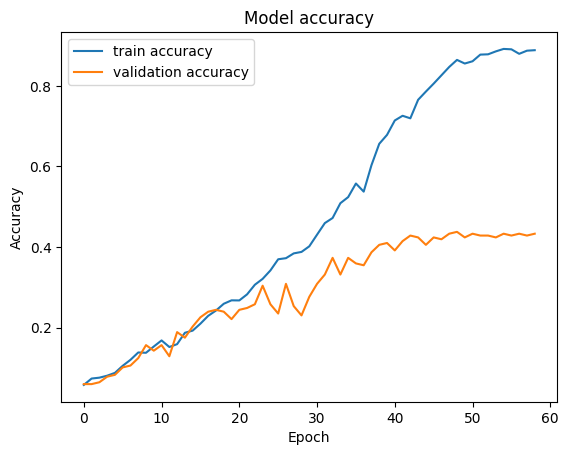

In [9]:
google_net_wrapper.plot_accuracy()

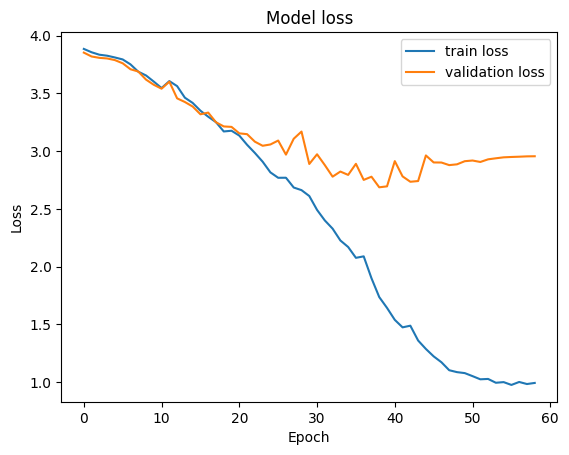

In [10]:
google_net_wrapper.plot_loss()

20/20 [==============================] - 0s 9ms/step


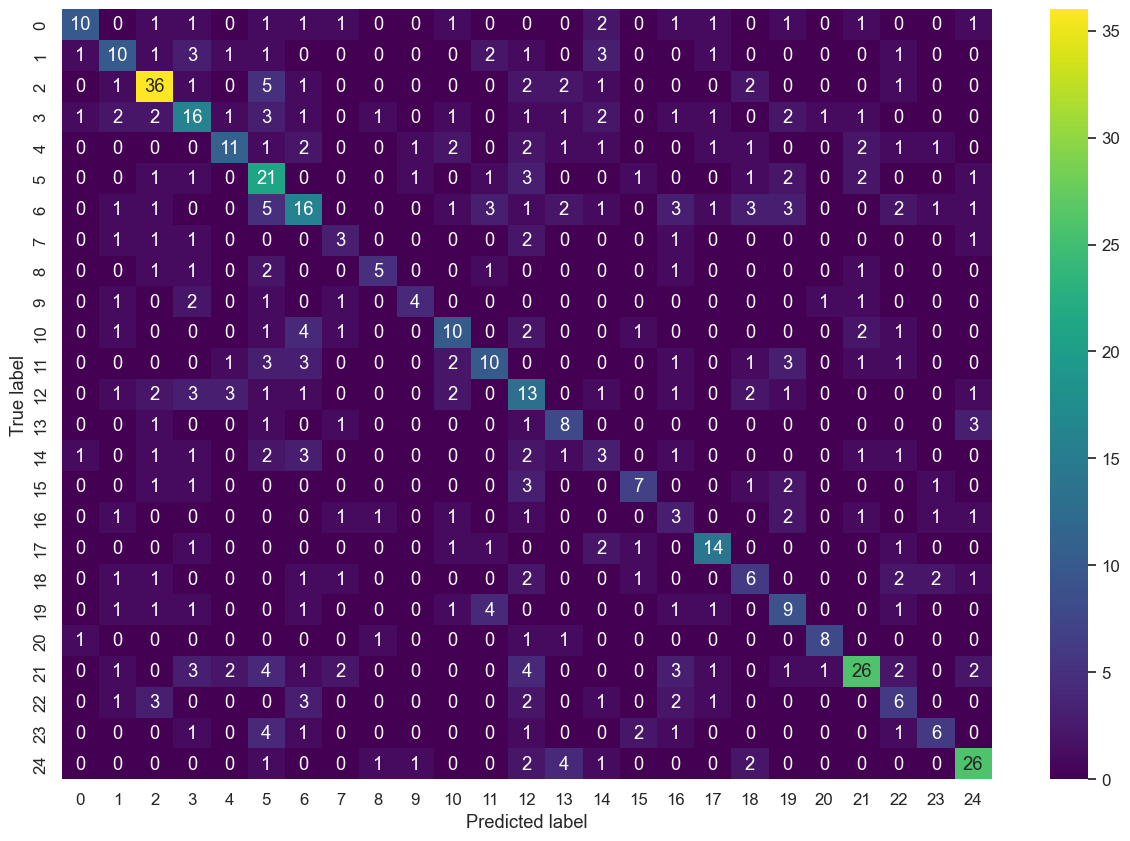

In [11]:
google_net_wrapper.display_confusion_matrix()